# Machine Learning Exercises
In this exercise, we will illustrate concepts from the machine learning class slides. First, we will walk through a confusion matrix exercise. Then, we will apply these concepts to logistic regression predictions. Finally, we will perform a k-means clustering technique on a sample of recent condo and apartment sales around campus. The purpose is to familiarize you with supervised and unsupervised machine learning basics.

## General housekeeping items

We will rely on common libraries that we have used in earlier exercises. We will also use some new libraries that are common in machine learning applications. Let’s begin by importing the necessary libraries.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from statsmodels.genmod.families import Binomial
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score
from sklearn.cluster import KMeans
from xgboost import XGBClassifier

## Confusion matrix example
A confusion matrix is a table used to describe the performance of classifications (or predictions) for which the true values are known. In class, we illustrated the concept of a confusion matrix that evaluated the accuracy of an economist's recession predictions. Let’s work through that example here. We will start by importing the data.

In [17]:
cm_example = pd.read_excel('cm_example.xlsx')

cm_example.head()

,year,recession,prediction
0,1980,Recession,Recession
1,1981,Recession,Recession
2,1982,Recession,Recession
3,1983,Not Recession,Recession
4,1984,Not Recession,Not Recession


Next, we will create a confusion matrix to evaluate the accuracy of the economist's predictions.

In [18]:
cm_table = pd.crosstab(cm_example['recession'], cm_example['prediction'], rownames=["Actual"], colnames=["Predicted"], dropna=False)

cm_table

Predicted,Not Recession,Recession
Actual,,
Not Recession,8,23
Recession,0,10


Note that in DataSpell, you can sort and reorganize the columns and rows by clicking on the column/row headers. Next, let’s make a 'fancier' visualization of the confusion matrix using a heatmap.

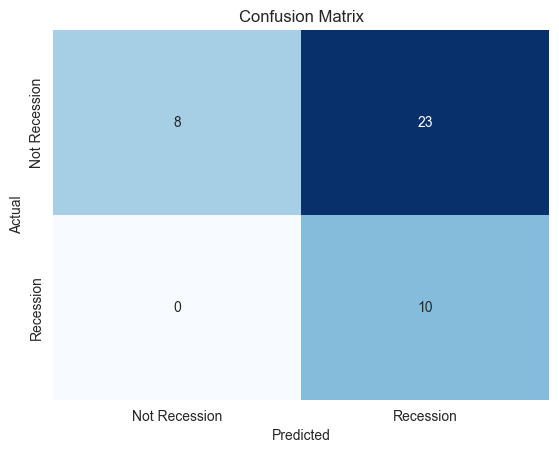

In [19]:
sns.heatmap(data = cm_table,
            annot=True,
            cmap='Blues',
            cbar=False
            )

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Above, we created the confusion matrix using the pandas crosstab function. However, there is also a function in `scikit-learn` that can create confusion matrices and other classification metrics. Let’s try it out below.

In [20]:
y_true = cm_example['recession']
y_pred = cm_example['prediction']

cm = confusion_matrix(y_true, y_pred, labels=['Not Recession', 'Recession'])
print(cm)

[[ 8 23]
 [ 0 10]]


We can also calculate common classification metrics such as accuracy, recall, and precision using `scikit-learn` functions. Let’s try it out below.

In [21]:
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred, pos_label='Recession')
precision = precision_score(y_true, y_pred, pos_label='Recession')

print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")

Accuracy: 0.439
Recall: 1.000
Precision: 0.303


Also, we can generate a full classification report using `scikit-learn`. Let’s try it out below.

In [22]:
cc_report = classification_report(y_true, y_pred)
print(f"Classification Report:\n{cc_report}")

Classification Report:
               precision    recall  f1-score   support

Not Recession       1.00      0.26      0.41        31
    Recession       0.30      1.00      0.47        10

     accuracy                           0.44        41
    macro avg       0.65      0.63      0.44        41
 weighted avg       0.83      0.44      0.42        41



## Exercise using logistic regression and default data

Logistic regression can be thought of as a machine learning method that can be used to predict binary outcomes. Let’s try using logistic regression to predict defaults using a dataset from [University of California - Irvine Machine Learning Repository](https://archive.ics.uci.edu/) called “[default of credit card clients](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients).” The file is already included in the repo. Let's import it.

In [37]:
cc_defaults = pd.read_csv('cc_defaults.csv', sep = ',')

cc_defaults.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Take a look at the dataset above and inspect the details from the [source](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients). Here we want to predict the column `default_payment_next_month`. Let's use some basic wrangling to create a set of plausible predictors for default.

Note, this is a simple set of predictors for illustration purposes only. Consider creating new variables that might help you predict default! You could do better!

In [24]:
# Debt to limit ratio
cc_defaults['dtl_ratio'] = cc_defaults['bill_amt1'] / cc_defaults['limit_bal']

# Change in debt to limit ratio
cc_defaults['dtl_ratio_change'] = (cc_defaults['bill_amt1'] - cc_defaults['bill_amt6']) / cc_defaults['limit_bal']

# Indicator if ever behind on payments in the last few months (any pay_0:pay_6 > 0)
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']
cc_defaults['behind'] = (cc_defaults[pay_cols] > 0).any(axis=1)

# Average payment status over the past few months
cc_defaults['avg_status'] = cc_defaults[pay_cols].mean(axis=1)

# Create a column called 'default'
cc_defaults['default'] = cc_defaults['default_payment_next_month']

# Select desired columns
cc_defaults = cc_defaults[['default', 'dtl_ratio', 'dtl_ratio_change', 'behind', 'avg_status']]

Now, let’s illustrate “training” and “testing” by splitting the sample into training and testing datasets. Here, we are going to randomly keep 70% of the original dataset and store as “train_data”. The remaining data will be stored as “test_data”.

In [25]:
cc_train_data, cc_test_data = train_test_split(cc_defaults, train_size=0.7, random_state=42, shuffle=True)

Next, estimate a logistic regression on the training dataset and use the estimated model to predict outcomes in testing dataset.

Note: Here, we convert the ‘fitted’ values to a binary prediction to force the model to predict either a 1 or a 0 (e.g., greater than 0.5 is predicted to be a 1, and less than 0.5 is predicted to be a 0). However, we can tinker with that threshold to make the predictions more/less conservative.

In [26]:
cc_train_logit = smf.glm("default ~ dtl_ratio + dtl_ratio_change + behind + avg_status", data=cc_train_data, family=Binomial()).fit()

print(cc_train_logit.summary())

cc_test_data['.fitted'] = cc_train_logit.predict(cc_test_data)
cc_test_data['default_pred'] = (cc_test_data['.fitted'] > 0.5).astype(int)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                default   No. Observations:                21000
Model:                            GLM   Df Residuals:                    20995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9706.4
Date:                Wed, 12 Nov 2025   Deviance:                       19413.
Time:                        13:36:22   Pearson chi2:                 2.19e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1272
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.9139      0.040  

Now that we have both actual and predicted outcomes in the same dataset, let’s create a confusion matrix as above.

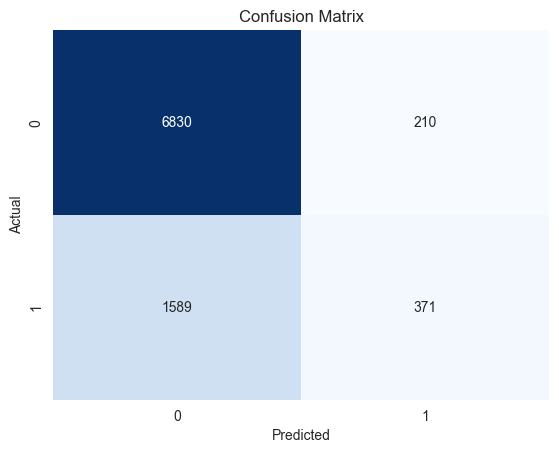

In [27]:
cm_table_logit = pd.crosstab(cc_test_data['default'], cc_test_data['default_pred'], rownames=["Actual"], colnames=["Predicted"], dropna=False)

sns.heatmap(data=cm_table_logit,
            annot=True,
            fmt='g',
            cmap='Blues',
            cbar=False
            )

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Can you label the false positives, false negatives, true positives, and true negatives? Next, let's calculate some classification metrics.

In [28]:
cc_default = cc_test_data['default']
cc_default_pred = cc_test_data['default_pred']

cc_cm = confusion_matrix(cc_default, cc_default_pred)
print(f"Confusion Matrix:\n{cc_cm}")

cc_report = classification_report(cc_default, cc_default_pred)
print(f"Classification Report:\n{cc_report}")


Confusion Matrix:
[[6830  210]
 [1589  371]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      7040
           1       0.64      0.19      0.29      1960

    accuracy                           0.80      9000
   macro avg       0.72      0.58      0.59      9000
weighted avg       0.77      0.80      0.75      9000



Can you interpret the values for accuracy, precision, and recall? Tinker with the prediction threshold and see what happens to these values?

## Machine learning - gradient boosting (using XGBoost)

Let’s repeat the analysis using the credit card data above, this time using decision tree algorithms from machine learning. Here we are going to use a popular technique called Extreme Gradient Boosting from the `xgboost` library.

In [29]:
# Remove the predictions from the test data that we generated above
cc_test_data = cc_test_data[['default', 'dtl_ratio', 'dtl_ratio_change', 'behind', 'avg_status']]

# Split predictors and target (note that the first column is the predicted target and the remaining columns are the predictors)
x_train = cc_train_data.iloc[:, 1:]
y_train = cc_train_data.iloc[:, 0]

x_test = cc_test_data.iloc[:, 1:]
y_test = cc_test_data.iloc[:, 0]

# Initialize XGBoost classifier
xgb_model = XGBClassifier(
    booster='gbtree',              # Use decision tree-based boosting
    objective='binary:logistic',   # For binary classification using logistic regression
    eval_metric='auc',             # Evaluate model performance using AUC (Area Under the Curve)
    max_depth=6,                   # Maximum depth of each decision tree (controls model complexity)
    learning_rate=0.05,            # Step size shrinkage to prevent overfitting (smaller = slower but safer)
    gamma=0,                       # Minimum loss reduction required to make a further partition (higher = more conservative)
    n_estimators=100,              # Number of boosting rounds (i.e., number of trees)
    random_state=42,               # Set random seed for reproducible results
    n_jobs=-1                      # Use all available CPU cores for faster training
)

# Fit the model to the training data
xgb_model.fit(x_train, y_train)

# Predict probabilities for the test data and apply a prediction threshold of 0.5
y_proba = xgb_model.predict_proba(x_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, digits=2))

Confusion Matrix:
 [[6672  368]
 [1390  570]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      7040
           1       0.61      0.29      0.39      1960

    accuracy                           0.80      9000
   macro avg       0.72      0.62      0.64      9000
weighted avg       0.78      0.80      0.78      9000



Is this better? While outside the scope of this lesson, we can "tune" the model parameters to improve predictions or adjust tradeoffs between different metrics. Tinker with the values above and see what happens!

## Clustering exercise

In this repo, you will find a dataset containing information on sales of condos, apartments, and townhomes from around the University of Alabama’s campus.<sup>[1](#fn1)</sup>  Let’s begin by importing and inspecting the dataset:

In [30]:
campus_condo_data = pd.read_csv('campus_condo_data.csv')

campus_condo_data.head()

,date_sold,sales_price,address,bedrooms,bathrooms,square_feet,home_type,year_built,neighborhood,lat,long,age
0,2022-05-20T00:00:00Z,320000.0,"2150 3rd Ct APT 307, Tuscaloosa, AL 35401",3,3.0,1700,Townhouse,2014,Forest Lake,33.191987,-87.541225,8
1,2022-05-20T00:00:00Z,174900.0,"120 15th St E APT 918, Tuscaloosa, AL 35401",2,2.0,1040,Condominium,1991,University,33.200948,-87.535077,31
2,2022-05-20T00:00:00Z,150000.0,"210 15th St E APT 35, Tuscaloosa, AL 35401",2,2.0,995,Condominium,1985,University,33.199175,-87.533809,37
3,2022-05-19T00:00:00Z,185000.0,"1901 5th Ave E UNIT 2106, Tuscaloosa, AL 35401",2,2.0,1112,Condominium,2007,Forest Lake,33.193640,-87.529761,15
4,2022-05-16T00:00:00Z,167000.0,"120 15th St E APT 519, Tuscaloosa, AL 35401",2,2.0,1040,Condominium,1991,University,33.200992,-87.535368,31


Let's estimate a regression predicting the sales price of a house based on size, bedrooms, and age. Can you interpret the output?

In [31]:
pricefit1 = smf.ols("np.log(sales_price) ~ np.log(square_feet) + bedrooms + np.log(age+1)", data=campus_condo_data).fit()

results_table = summary_col(pricefit1,
                            stars=True,
                            info_dict={'N': lambda x: f"{int(x.nobs)}", })

print(results_table)


                    np.log(sales_price)
---------------------------------------
Intercept           8.7269***          
                    (0.6934)           
np.log(square_feet) 0.6968***          
                    (0.1026)           
bedrooms            -0.0562            
                    (0.0360)           
np.log(age + 1)     -0.4147***         
                    (0.0211)           
R-squared           0.6294             
R-squared Adj.      0.6277             
N                   660                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


Let's suppose you wanted to add location to your regression. We have some information on latitude and longitude... around Tuscaloosa, we could think of these as simply coordinates on a map. We might try seeing if we can find groups of properties that were sold near each other. This a great task for an unsupervised learning technique called clustering. First, we will isolate the latitude and longitude variables and pass through the kmeans clustering function. We will start by isolating 2 clusters to group the data into.

In [32]:
# Select the lat/long columns
latlong = campus_condo_data[['long', 'lat']].copy()

# Fit k-means clustering with 2 clusters, 25 random starts
kmeans = KMeans(n_clusters=2,
                n_init=25,
                random_state=42
                )

clusters = kmeans.fit(latlong)

# Store the cluster assignments in a new column
latlong['cluster'] = clusters.labels_

Since latitude and longitude are two dimensional, we can easily plot our data to see how the observations are classified.

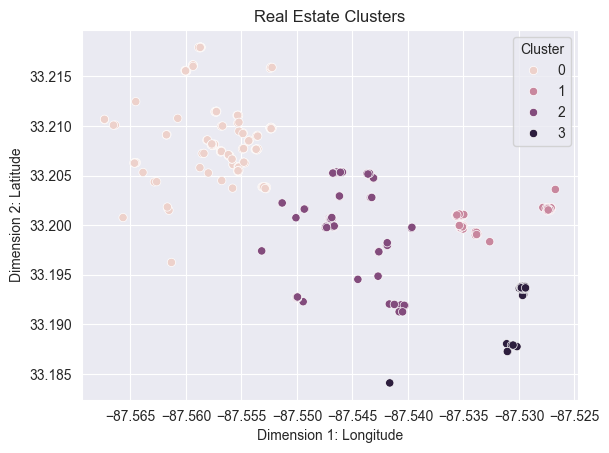

In [39]:
sns.scatterplot(data=latlong,
                x='long',
                y='lat',
                hue='cluster'
                )

plt.title('Real Estate Clusters')
plt.xlabel('Dimension 1: Longitude')
plt.ylabel('Dimension 2: Latitude')
plt.legend(title='Cluster')
plt.show()

As you can see, we have discretion over the number of clusters to select. It is useful to investigate how adding clusters helps differentiate groups of similar observations. There are no “hard and fast” rules when determining the "right" number of clusters. Ultimately, it is up to you to determine the number of clusters that work best in your setting. However, it is a useful exercise to evaluate how much each additional cluster improves the classifications. One way that we can do this is to use a “scree_plot” that shows how much incremental variation is explained when adding additional clusters.

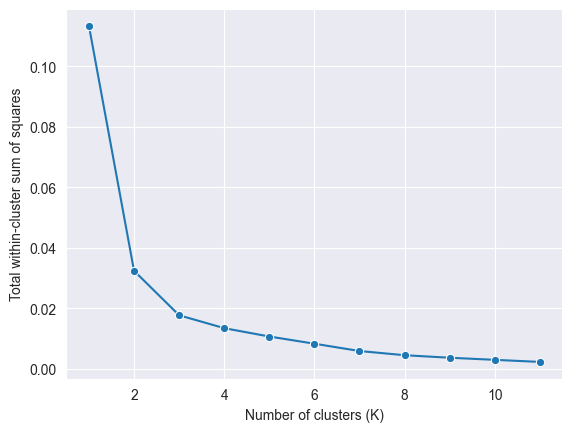

In [34]:
# Select the lat/long columns
latlong = campus_condo_data[['long', 'lat']].copy()

# Loop several iterations of k-means clustering increasing number of clusters each time
k_values = range(1, 12)

wss_values = []
for k in k_values:
    model = KMeans(n_clusters=k,
                   n_init=25,
                   random_state=42
                   )
    model.fit(latlong)
    wss_values.append(model.inertia_)  # inertia_ = total within-cluster SSE

# Generate a scree plot of the results from each loop
sns.lineplot(x=list(k_values),
             y=wss_values,
             marker='o')

plt.xlabel('Number of clusters (K)')
plt.ylabel('Total within-cluster sum of squares')
plt.show()


As you can see, the improvement in similiarity among observations within each group declines as we add clusters. Let's reperform the clustering exercise above, this time using 4 clusters.

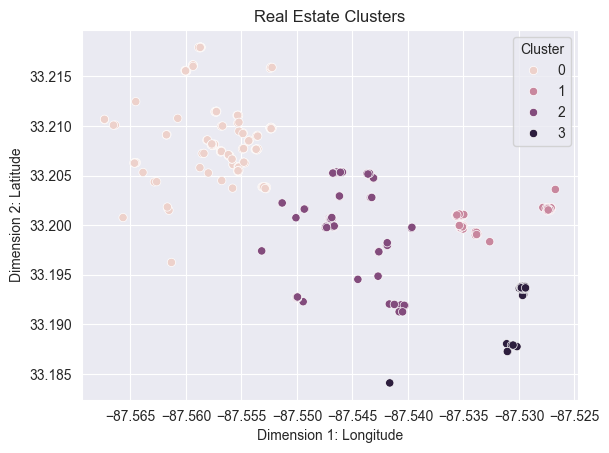

In [38]:
latlong = campus_condo_data[['long', 'lat']].copy()

kmeans = KMeans(n_clusters=4,
                n_init=25,
                random_state=42
                )

clusters = kmeans.fit(latlong)

latlong['cluster'] = clusters.labels_

sns.scatterplot(data=latlong,
                x='long',
                y='lat',
                hue='cluster'
                )

plt.title('Real Estate Clusters')
plt.xlabel('Dimension 1: Longitude')
plt.ylabel('Dimension 2: Latitude')
plt.legend(title='Cluster')
plt.show()

Finally, let’s add the clusters to the original dataset. Then, let’s reestimate the regression predicting the sales price of a house based on size, bedrooms, age, and location (cluster). Can you interpret the output?

In [36]:
campus_condo_data['cluster'] = clusters.labels_

pricefit2 = smf.ols("np.log(sales_price) ~ np.log(square_feet) + bedrooms + np.log(age+1) + C(cluster)", data=campus_condo_data).fit()

results_table = summary_col([pricefit1, pricefit2],
                            stars=True,
                            info_dict={'N': lambda x: f"{int(x.nobs)}", })

print(results_table)


                    np.log(sales_price) I np.log(sales_price) II
----------------------------------------------------------------
Intercept           8.7269***             8.8698***             
                    (0.6934)              (0.4867)              
np.log(square_feet) 0.6968***             0.6758***             
                    (0.1026)              (0.0720)              
bedrooms            -0.0562               0.0005                
                    (0.0360)              (0.0254)              
np.log(age + 1)     -0.4147***            -0.3180***            
                    (0.0211)              (0.0155)              
C(cluster)[T.1]                           -0.6068***            
                                          (0.0330)              
C(cluster)[T.2]                           -0.3156***            
                                          (0.0321)              
C(cluster)[T.3]                           -0.8447***            
                        

<a id="fn1"><sup>1</sup></a> The data was collected from Zillow in July 2022. The campus_condo_data data includes apartment, condominium, and townhouse sales from Zillow from November 2019 through May 2022. The data was collected from May 2022-July 2022. The search includes sales in Tuscaloosa inside of 359, Warrior River, McFarland Blvd, and 37th E Street. The data was filtered to remove observations with missing values (e.g., incomplete cases), outliers (e.g., sales price of $100), or unlikely to be individual sales (e.g., multiple units included in same sale). Latitude and longitude were obtained from Google Maps, remaining variables were obtained from Zillow. A big thanks to Kimberly Niven, Sara Buroughs, and Taryn Johnson for collecting this data.